# Customization and import

In [4]:
import gc
import logging
import os
from subprocess import check_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import torch
import torch.nn as nn
import transformers
from sklearn.metrics import (classification_report, precision_recall_curve,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import (AdamW, BertModel, BertTokenizer,
                          get_linear_schedule_with_warmup)

%matplotlib inline
py.init_notebook_mode(connected=True)


logging.disable(logging.WARNING)

In [ ]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data analysis

In [ ]:
df = pd.read_csv("../../data/train.csv")

In [ ]:
print("Number of data points:", df.shape[0])
df.head()

In [ ]:
df.info()

In [ ]:
df.isna().sum()

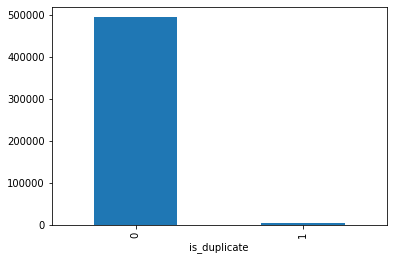

In [ ]:
# number of duplicate(smilar) and non-duplicate(non similar) company names

df.groupby("is_duplicate")["pair_id"].count().plot.bar()

In [ ]:
print(
    "~> Pairs of companies are not Similar (is_duplicate = 0):\n   {}%".format(
        100 - round(df["is_duplicate"].mean() * 100, 2)
    )
)
print(
    "\n~> Pairs of companies are Similar (is_duplicate = 1):\n   {}%".format(
        round(df["is_duplicate"].mean() * 100, 2)
    )
)

~> Pairs of companies are not Similar (is_duplicate = 0):
   99.27%

~> Pairs of companies are Similar (is_duplicate = 1):
   0.73%


Draw graph which shows number of words in both company names

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



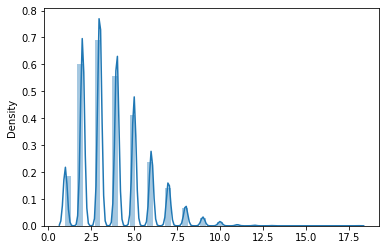

In [ ]:
train_sentences_lens = df["name_1"].apply(lambda x: len(x.split(" "))).tolist()
train_sentences_lens.extend(df["name_2"].apply(lambda x: len(x.split(" "))).tolist())
sns.distplot(train_sentences_lens)

In [ ]:
MAX_LEN = 15

In [ ]:
# number of unique company names

cids = pd.Series(df["name_1"].tolist() + df["name_2"].tolist())
unique_cs = len(np.unique(cids))

cs_morethan_onetime = np.sum(cids.value_counts() > 1)
print("Total number of unique company names: {}\n".format(unique_cs))

print(
    "Number of unique company names that appear more than one time: {} ({}%)\n".format(
        cs_morethan_onetime, cs_morethan_onetime / unique_cs * 100
    )
)

print(
    "Max number of times a single company names is repeated: {}\n".format(
        max(cids.value_counts())
    )
)

c_vals = cids.value_counts()

c_vals = c_vals.values


Total number of unique company names: 18022

Number of unique company names that appear more than one time: 17465 (96.90933303739874%)

Max number of times a single company names is repeated: 2861



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



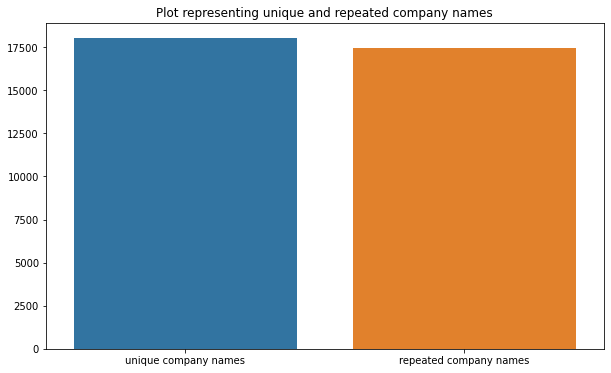

In [ ]:
x = ["unique company names", "repeated company names"]
y = [unique_cs, cs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title("Plot representing unique and repeated company names")
sns.barplot(x, y)
plt.show()

In [ ]:
# checking whether there are any repeated pair of company names

pair_duplicates = (
    df[["name_1", "name_2"]]
    .groupby(["name_1", "name_2"])
    .size()
    .reset_index(name="count")
)

print("Number of duplicate company names: ", (pair_duplicates).shape[0] - df.shape[0])



Number of duplicate company names:  0


Maximum number of times a single names is repeated: 2861



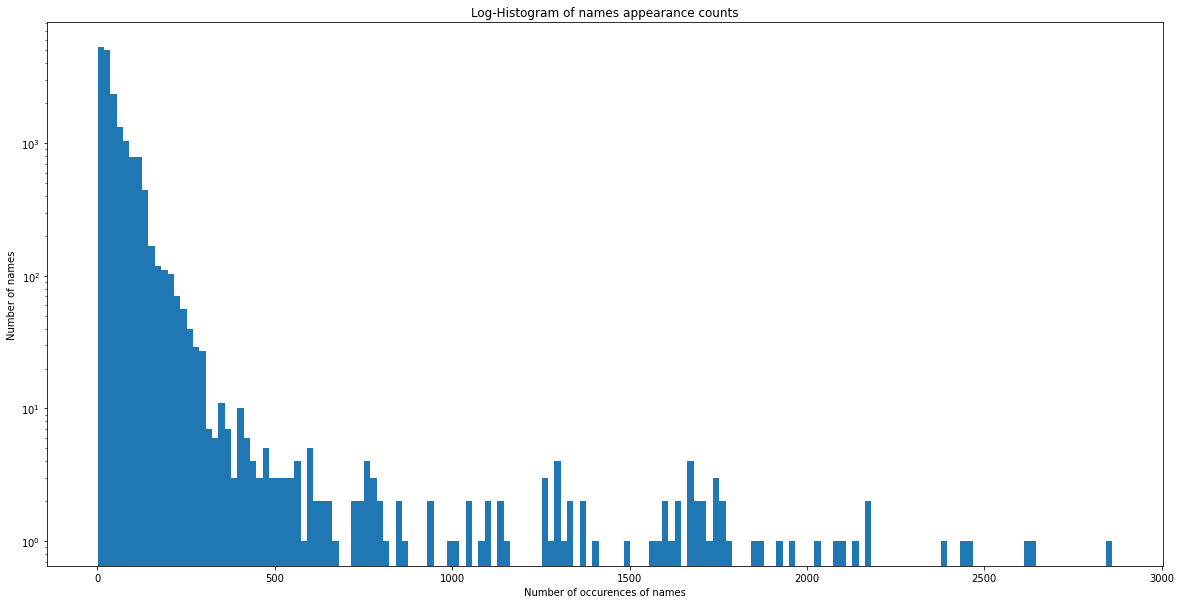

In [ ]:
# number of occurrences of each company names

plt.figure(figsize=(20, 10))

plt.hist(cids.value_counts(), bins=160)

plt.yscale("log", nonposy="clip")

plt.title("Log-Histogram of names appearance counts")

plt.xlabel("Number of occurences of names")

plt.ylabel("Number of names")

print(
    "Maximum number of times a single names is repeated: {}\n".format(
        max(cids.value_counts())
    )
)


In [ ]:
# checking whether there are any rows with null values

nan_rows = df[df.isnull().any(1)]
print(nan_rows)
df.isnull().sum().sum()

Empty DataFrame
Columns: [pair_id, name_1, name_2, is_duplicate, c1len, c2len, c1_n_words, c2_n_words, word_Common, word_Total, word_share]
Index: []


0

In [ ]:
df1 = df.copy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Preparation

In [ ]:
BERT_VERSION = "bert-base-uncased"
POOLED_OUTPUT_DIM = 768

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_VERSION)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# split data to train and validation sets

train_df, val_df = train_test_split(df1, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
class BertDataSet:
    def __init__(self, first_names, second_names, targets, tokenizer):
        self.first_names = first_names
        self.second_names = second_names
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = len(first_names)

    def __len__(self):
        return self.length

    def __getitem__(self, item):
        first_names = str(self.first_names[item])
        second_names = str(self.second_names[item])

        # removes extra white spaces from names
        first_names = " ".join(first_names.split())
        second_names = " ".join(second_names.split())

        ### [CLS] name_1 [SEP] name_2 [SEP] ... [PAD]
        inputs = self.tokenizer.encode_plus(
            first_names,
            second_names,
            add_special_tokens=True,
            padding="max_length",
            max_length=2 * MAX_LEN + 3, 
            truncation=True,
        )

        # return targets 0, when using data set in testing and targets are none
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype=torch.long)
            if self.targets is not None
            else 0,
        }

In [ ]:
# creates dataset and returns dataloader of it

def get_data_loader(df, targets, batch_size, shuffle, tokenizer):
    dataset = BertDataSet(
        first_names=df["name_1"].values,
        second_names=df["name_2"].values,
        targets=targets,
        tokenizer=tokenizer,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

In [ ]:
# training batch size we gonna use throughout this notebook

BS = 128

In [ ]:
# create data loaders of training and validation data

train_data_loader = get_data_loader(
    df=train_df,
    targets=train_df["is_duplicate"].values,
    batch_size=BS,
    shuffle=True,
    tokenizer=tokenizer,
)

val_data_loader = get_data_loader(
    df=val_df,
    targets=val_df["is_duplicate"].values,
    batch_size=4 * BS,
    shuffle=True,
    tokenizer=tokenizer,
)

# Model

In [ ]:
class BertModel(nn.Module):
    def __init__(self, bert_path):
        super(BertModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.BertModel.from_pretrained(
            self.bert_path, return_dict=False
        )
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(POOLED_OUTPUT_DIM, 1)

    def forward(self, ids, mask, token_type_ids):
        _, pooled = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)

        # add dropout to prevent overfitting
        pooled = self.dropout(pooled)
        return self.out(pooled)


model = BertModel(BERT_VERSION).to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
with open("../../weights/BERT/saved_model", "rb") as f:
    state_dict = torch.load(f, map_location=torch.device("cpu"))
model.load_state_dict(state_dict, strict=False)
model.to(device)

BertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

# Training

In [ ]:
# loss function is simple binary cross entropy loss
# need sigmoid to put probabilities in [0,1] interval

def loss_fn(outputs, targets):
    outputs = torch.squeeze(outputs)
    return nn.BCELoss()(nn.Sigmoid()(outputs), targets)

In [ ]:
# computes perplexity on validation data

def calculate_perplexity(data_loader, model, device):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        for batch in data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            total_loss += loss_fn(outputs, targets).item()
            
    model.train()

    return np.exp(total_loss / len(data_loader))

In [ ]:
def train_loop(
    epochs, train_data_loader, val_data_loader, model, optimizer, device, scheduler=None
):
    it = 1
    total_loss = 0
    curr_perplexity = None
    perplexity = None

    model.train()
    for epoch in range(epochs):
        print("Epoch: ", epoch + 1)
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            optimizer.zero_grad()

            outputs = model(ids, mask=mask, token_type_ids=token_type_ids)

            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            loss.backward()

            optimizer.step()

            # we are logging current loss/perplexity in every 100 iteration
            if it % 100 == 0:

                # computing validation set perplexity in every 500 iteration
                if it % 500 == 0:
                    curr_perplexity = calculate_perplexity(
                        val_data_loader, model, device
                    )

                    if scheduler is not None:
                        scheduler.step()

                    # making checkpoint of best model weights
                    if not perplexity or curr_perplexity < perplexity:
                        torch.save(model.state_dict(), "../../weights/BERT/saved_model")
                        perplexity = curr_perplexity

                print(
                    "| Iter",
                    it,
                    "| Avg Train Loss",
                    total_loss / 100,
                    "| Dev Perplexity",
                    curr_perplexity,
                )
                total_loss = 0

            it += 1


In [ ]:
def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 1

    lr = 3e-5
    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr=lr, no_deprecation_warning=True)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    train_loop(
        EPOCHS, train_data_loader, val_data_loader, model, optimizer, device, scheduler
    )

In [ ]:
run(model, train_df, device, train_data_loader, val_data_loader)

Epoch:  1
| Iter 100 | Avg Train Loss 0.07296604611445218 | Dev Perplexity None
| Iter 200 | Avg Train Loss 0.012961357779568061 | Dev Perplexity None
| Iter 300 | Avg Train Loss 0.01152106503781397 | Dev Perplexity None
| Iter 400 | Avg Train Loss 0.007186858104541898 | Dev Perplexity None
| Iter 500 | Avg Train Loss 0.00727346638799645 | Dev Perplexity 1.004436647255779
| Iter 600 | Avg Train Loss 0.006204644675599411 | Dev Perplexity 1.004436647255779
| Iter 700 | Avg Train Loss 0.007413944325671764 | Dev Perplexity 1.004436647255779
| Iter 800 | Avg Train Loss 0.005065080904023489 | Dev Perplexity 1.004436647255779
| Iter 900 | Avg Train Loss 0.0054050164434011096 | Dev Perplexity 1.004436647255779
| Iter 1000 | Avg Train Loss 0.004329091270192293 | Dev Perplexity 1.003573361005335
| Iter 1100 | Avg Train Loss 0.005329993242630735 | Dev Perplexity 1.003573361005335
| Iter 1200 | Avg Train Loss 0.007748912575625582 | Dev Perplexity 1.003573361005335
| Iter 1300 | Avg Train Loss 0.00

# Testing

In [ ]:
# this function returns probabilities for every test case

def test(model, test_df, device):
    predictions = torch.empty(0).to(device, dtype=torch.float)
    real = torch.empty(0).to(device, dtype=torch.long)

    test_dataset = BertDataSet(
        first_names=test_df["name_1"].values,
        second_names=test_df["name_2"].values,
        targets=test_df["is_duplicate"].values,
        tokenizer=tokenizer,
    )

    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_data_loader):
            ids = batch["ids"]
            mask = batch["mask"]
            token_type_ids = batch["token_type_ids"]
            targets = batch["targets"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            predictions = torch.cat((predictions, nn.Sigmoid()(outputs)))
            real = torch.cat((real, targets.to(device)))

    return predictions.cpu().numpy().squeeze(), real.cpu().numpy().squeeze()


predictions = test(model, val_df, device)
len(predictions)

100%|██████████| 98/98 [01:45<00:00,  1.08s/it]


2

In [ ]:
probas, real = predictions

Quality of education

In [ ]:
auc = roc_auc_score(y_true=real, y_score=probas)
print(f"AUC score: {auc:0.3f}")

AUC score: 0.997


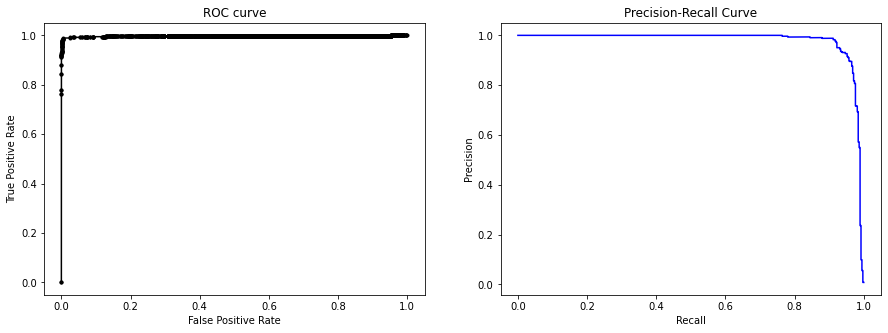

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

precision, recall, threshold = precision_recall_curve(y_true=real, probas_pred=probas)
fpr, tpr, threshold = roc_curve(y_true=real, y_score=probas)

ax1.plot(fpr, tpr, marker=".", color="k")

ax1.set_title("ROC curve")
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("False Positive Rate")

ax2.plot(recall, precision, color="b")

ax2.set_title("Precision-Recall Curve")
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")
plt.show()

In [ ]:
# write down answers in is_duplicate column

val_df["is_duplicate"] = probas

# Evaluation

In [ ]:
# prints if two names is similar and score of confidence

def eval(model, tokenizer, first_names, second_names, device):
    inputs = tokenizer.encode_plus(
        first_names,
        second_names,
        add_special_tokens=True,
    )

    ids = torch.tensor([inputs["input_ids"]], dtype=torch.long).to(
        device, dtype=torch.long
    )
    mask = torch.tensor([inputs["attention_mask"]], dtype=torch.long).to(
        device, dtype=torch.long
    )
    token_type_ids = torch.tensor([inputs["token_type_ids"]], dtype=torch.long).to(
        device, dtype=torch.long
    )

    with torch.no_grad():
        model.eval()
        output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        prob = nn.Sigmoid()(output).item()

        print(
            "Company names [{}] and [{}] are {} with score {}".format(
                first_names,
                second_names,
                "similar" if prob > 0.5 else "not similar",
                prob,
            )
        )

In [ ]:
# change names to test model

first_name = "Dow Chemical International Private Ltd."
second_name = "Dow Chemical Pacific"

eval(model, tokenizer, first_name, second_name, device)

Company names [Dow Chemical International Private Ltd.] and [Dow Chemical Pacific	] are similar with score 0.9906879663467407
